In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned+\dataset+.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned+\target.csv', header = 0)

[(0, 'balance'), (1, 'lifetime'), (2, 'tx_in'), (3, 'tx_out'), (4, 'investment_in'), (5, 'payment_out'), (6, 'investment_to_contract/tx_in'), (7, 'payment_from_contract/tx_out'), (8, '#addresses_paying_contract'), (9, '#addresses_paid_by_contract'), (10, 'mean_v1'), (11, 'sdev_v1'), (12, 'mean_v2'), (13, 'sdev_v2'), (14, 'paid_rate'), (15, 'paid_one'), (16, 'percentage_some_tx_in'), (17, 'sdev_tx_in'), (18, 'percentage_some_tx_out'), (19, 'sdev_tx_out'), (20, 'known_rate'), (21, 'owner_gets_eth_Wo_investing'), (22, 'owner_gets_eth_investing'), (23, 'owner_no_eth')]


In [3]:
X_address = dataset.values[:, :] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train_address, X_test_address, y_train, y_test = train_test_split(X_address, y, test_size=0.2, random_state = 42, stratify=y) 
X_train = X_train_address[:, 1:]
X_test = X_test_address[:, 1:]
df= pd.DataFrame(data=X_train, columns=features_names)

In [4]:
# vado a stampare il numero di non ponzi e ponzi presenti nel train set e nel test_set

flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))

Number of smart contract in train set:: 3107
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 777
Number of smart Ponzi in test set:: 135


In [5]:
fbeta = make_scorer(fbeta_score, beta = 1.5)

In [28]:
param_dist_DT = {
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [8, 9, 10, 11, 12],
            'min_samples_split' : [30, 35], # il valore tipico sta fra 1 e 40
            'class_weight': [{0:1, 1:5}]
}

In [29]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_dist_DT, scoring = fbeta, cv = 3, n_jobs = 8)
grid_dt.fit(X_train, y_train) # alleno su train
y_pred_train = grid_dt.predict(X_train) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'class_weight': {0: 1, 1: 5}, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 35}
best score::  0.5993546588142026
recall score on TR::  0.8643122676579925
precision score on TR::  0.48538622129436326


In [30]:
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_dt.score(X_train, y_train))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8447187928669411
accuracy score on TS::  0.8135964912280702


In [32]:
param_dist_RF = {
            'n_estimators':[180, 190, 200, 210],
            'min_samples_split' : [35, 40],
            'max_depth' : [6,7,8],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:5.5}, {0:1, 1:6}],
            'bootstrap': [True, False]
}

In [33]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_dist_RF, scoring = fbeta, cv = 3, n_jobs = 8)
grid_rf.fit(X_train, y_train.ravel())
y_pred_train = grid_rf.predict(X_train)
print('best hyperparameters:: ', grid_rf.best_params_)
print('best score:: ', grid_rf.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'bootstrap': False, 'class_weight': {0: 1, 1: 6}, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 40, 'n_estimators': 190}
best score::  0.6162261967671614
recall score on TR::  0.8903345724907064
precision score on TR::  0.4719211822660099


In [34]:
clf_rf = RandomForestClassifier(**grid_rf.best_params_)
clf_rf.fit(X_train, y_train.ravel())
print('accuracy score on TR:: ', clf_rf.score(X_train, y_train))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.8392318244170096
accuracy score on TS::  0.8037280701754386


In [39]:
grid_param_XGB = {
                'learning_rate' : [0.05],
                'n_estimators' : [70, 80, 90, 100, 110, 120],
                'max_depth': [6, 7, None],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'scale_pos_weight' : [5, 5.5, 6],
                'reg_lambda' : [10, 100]
}

In [40]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'aucpr'), 
                        param_grid = grid_param_XGB, scoring = fbeta, cv = 3, n_jobs = 8)
grid_xgb.fit(X_train, y_train)
y_pred_train = grid_xgb.predict(X_train)
print('best hyperparameters:: ', grid_xgb.best_params_)
print('best score:: ', grid_xgb.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 10, 'scale_pos_weight': 6, 'subsample': 0.8}
best score::  0.6493051755663161
recall score on TR::  0.8866171003717472
precision score on TR::  0.6973684210526315


In [41]:
clf_xgb = xgb.XGBClassifier(learning_rate = 0.05, n_estimators = 100, scale_pos_weight = 5, max_depth=7, reg_lambda = 10,
                            subsample = 0.8, colsample_bytree = 0.8, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_xgb.score(X_train, y_train))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.9349794238683128
accuracy score on TS::  0.8760964912280702


In [43]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [8, 9, 10, 11, 12],
            'min_samples_split' : [30, 35], # il valore tipico sta fra 1 e 40
            'class_weight': [{0:1, 1:5}]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[180, 190, 200, 210],
            'min_samples_split' : [35, 40],
            'max_depth' : [6,7,8],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:5.5}, {0:1, 1:6}],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(eval_metric = 'aucpr', use_label_encoder = False),
        'params': {
                'learning_rate' : [0.05],
                'n_estimators' : [70, 80, 90, 100, 110, 120],
                'max_depth': [6, 7, None],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'scale_pos_weight' : [5, 5.5, 6],
                'reg_lambda' : [10, 100]
        }
    }
}

In [44]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring = fbeta, cv = 3, return_train_score = False, n_jobs=8)
    clf.fit(X_train, y_train.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.597563,"{'class_weight': {0: 1, 1: 5}, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 30}"
1,random_forest,0.615454,"{'bootstrap': False, 'class_weight': {0: 1, 1: 5.5}, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 35, 'n_estimators': 180}"
2,xgboost,0.649305,"{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 10, 'scale_pos_weight': 6, 'subsample': 0.8}"


In [45]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train, y_train.ravel()) # rialleno

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='aucpr', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=6, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

                    (Number, Feature)  Importance
0                      (15, paid_one)    0.196813
1                    (20, known_rate)    0.145560
2                          (2, tx_in)    0.059130
3    (9, #addresses_paid_by_contract)    0.052909
4   (6, investment_to_contract/tx_in)    0.042213
5                    (17, sdev_tx_in)    0.042139
6                       (10, mean_v1)    0.038518
7   (7, payment_from_contract/tx_out)    0.038236
8                       (13, sdev_v2)    0.035588
9         (16, percentage_some_tx_in)    0.034263
10                      (1, lifetime)    0.029427
11                    (14, paid_rate)    0.027620
12                       (0, balance)    0.027077
13  (21, owner_gets_eth_Wo_investing)    0.024161
14                 (23, owner_no_eth)    0.023846
15       (18, percentage_some_tx_out)    0.023324
16                 (4, investment_in)    0.022753
17    (8, #addresses_paying_contract)    0.022725
18                      (11, sdev_v1)    0.021472


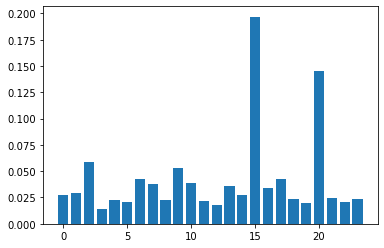

In [46]:
features_importances = clf.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

precision score::  0.5321637426900585
recall score::  0.674074074074074
accuracy score::  0.8640350877192983
fbeta score::  0.6229594523433386
F1 score:: 0.5947712418300654


<AxesSubplot:>

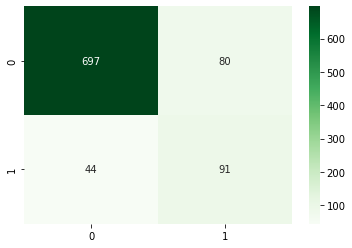

In [47]:
# faccio la predizione e stampo le statistiche sul modello migliore (quello che ha vinto nella GridSearch)

y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('fbeta score:: ', fbeta_score(y_test, y_pred, beta = 1.5))
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

precision score::  0.4219409282700422
recall score::  0.7407407407407407
accuracy score::  0.8114035087719298
F1 score:: 0.5376344086021505


<AxesSubplot:>

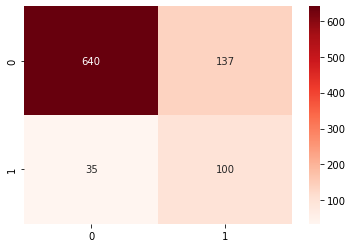

In [48]:
# risultati ottenuti con il secondo migliore

model = models_list[1] # prendo il modello medio
clf2 = model.get('best_estimator') # ottengo i valori con cui allenare
clf2.fit(X_train, y_train.ravel()) # rialleno
y_pred2 = clf2.predict(X_test)
#print(clf2.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred2)) #  TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred2))	     # 	TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred2))	 #  (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred2))
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')

                    (Number, Feature)  Importance
0                          (2, tx_in)    0.126022
1   (6, investment_to_contract/tx_in)    0.108489
2                      (15, paid_one)    0.095328
3                    (17, sdev_tx_in)    0.076758
4                    (20, known_rate)    0.071862
5                       (10, mean_v1)    0.060581
6                       (1, lifetime)    0.058824
7         (16, percentage_some_tx_in)    0.052496
8                     (14, paid_rate)    0.049027
9                       (13, sdev_v2)    0.045678
10   (9, #addresses_paid_by_contract)    0.040045
11    (8, #addresses_paying_contract)    0.032624
12                 (4, investment_in)    0.023847
13                      (11, sdev_v1)    0.023047
14       (18, percentage_some_tx_out)    0.019793
15                 (23, owner_no_eth)    0.019590
16  (7, payment_from_contract/tx_out)    0.016393
17                   (5, payment_out)    0.016137
18                        (3, tx_out)    0.016011


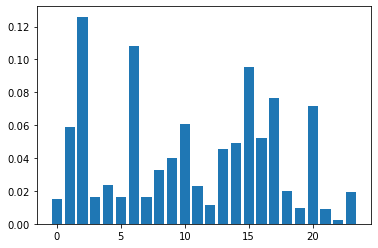

In [49]:
# importanza delle features nel secondo migliore

features_importances = clf2.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

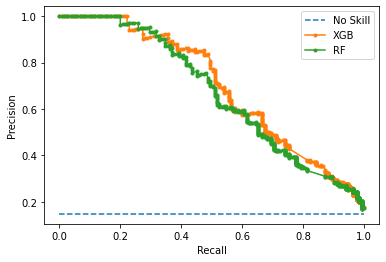

In [50]:
# predict probabilities
y_pred_proba_winner = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_pred_proba_w = y_pred_proba_winner[:, 1]
# calculate pr-curve
p, r, thrs = precision_recall_curve(y_test, y_pred_proba_w)


y_pred_proba_second = clf2.predict_proba(X_test)
y_pred_proba_s = y_pred_proba_second[:, 1]
p2, r2, thrs2 = precision_recall_curve(y_test, y_pred_proba_s)
# plot the roc curve for the model
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(r, p, marker = '.', label = 'XGB')
plt.plot(r2, p2, marker = '.', label = 'RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [51]:
# convert to f score
beta = 1.75 # se metto valori <= 1 allora e' come favorire F1 o precision, piu' alzo beta e piu' importanza ha la recall
fbetaw = ((1 + beta**2) * p * r) / (beta**2 * p + r)
# locate the index of the largest f score
ixw = np.argmax(fbetaw)
fbetas = ((1 + beta**2) * p2 * r2) / (beta**2 * p2 + r2)
ixs = np.argmax(fbetas)
print('Best Threshold of the winner model = %f, Fbeta-Score = %.3f' % (thrs[ixw], fbetaw[ixw]))
print('Best Threshold of the second model = %f, Fbeta-Score = %.3f' % (thrs2[ixs], fbetas[ixs]))

Best Threshold of the winner model = 0.422272, Fbeta-Score = 0.647
Best Threshold of the second model = 0.429700, Fbeta-Score = 0.628


precision score::  0.4647887323943662
recall score::  0.7333333333333333
accuracy score::  0.8355263157894737
fbeta score::  0.6226415094339621
F1 score:: 0.5689655172413793


<AxesSubplot:>

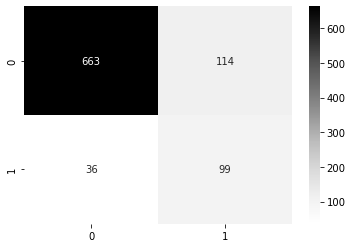

In [52]:
y_pred_thrs = np.where(clf.predict_proba(X_test)[:, 1] > thrs[ixw], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs)
print('precision score:: ', precision_score(y_test, y_pred_thrs)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred_thrs))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred_thrs))	 # (TP + TN)/ (TP + FN + TN + FP)
print('fbeta score:: ', fbeta_score(y_test, y_pred_thrs, beta = 1.5))
print('F1 score::', f1_score(y_test, y_pred_thrs))
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')

<AxesSubplot:>

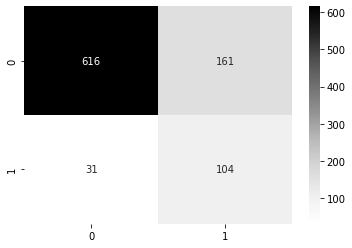

In [53]:
y_pred_thrs2 = np.where(clf2.predict_proba(X_test)[:, 1] > thrs2[ixs], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs2)
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')

In [19]:
# acquisico il numero dei contratti nel test set che sono falsi positivi o falsi negativi
list_pred = list(y_pred_thrs)
list_test = [item for sublist in y_test for item in sublist]

i = 0
fn_list, fp_list = [], []
while i < len(list_pred):
    if list_test[i] != list_pred[i]:
        if (list_test[i] == True) and (list_pred[i] == False):
            fn_list.append(i)
        elif (list_test[i] == False) and (list_pred[i] == True):
            fp_list.append(i)
    i+=1
            
print(fp_list)
print('false positive:: ', len(fp_list))
print()
print(fn_list)
print('false negative:: ', len(fn_list))

[7, 55, 64, 69, 73, 75, 77, 79, 80, 100, 105, 115, 117, 125, 126, 129, 132, 146, 160, 181, 182, 198, 199, 205, 215, 222, 242, 246, 247, 249, 263, 264, 265, 283, 284, 298, 323, 335, 339, 350, 352, 353, 358, 362, 365, 374, 376, 390, 407, 421, 429, 430, 435, 439, 440, 459, 473, 481, 485, 488, 491, 494, 513, 516, 518, 519, 525, 538, 543, 550, 553, 564, 580, 582, 586, 591, 593, 597, 599, 601, 615, 620, 632, 637, 668, 671, 674, 703, 706, 720, 721, 727, 730, 749, 750, 760, 786, 791, 808, 816, 826, 827, 833, 844, 846, 847, 849, 851, 853, 855, 866, 887, 895, 910]
false positive::  114

[12, 28, 53, 66, 71, 102, 135, 166, 169, 194, 220, 243, 315, 342, 348, 351, 375, 433, 477, 479, 526, 534, 546, 568, 584, 598, 603, 625, 648, 652, 768, 821, 837, 845, 871, 891]
false negative::  36


In [20]:
np.set_printoptions(threshold=sys.maxsize)

In [21]:
coordinates = clf.predict_proba(X_test)
fp_coordinates = [] 
i = 0

while i < len(fp_list):
    fp_coordinates.append(coordinates[fp_list[i]])
    i+=1

In [22]:
fn_coordinates = [] 
i = 0

while i < len(fn_list):
    fn_coordinates.append(coordinates[fn_list[i]])
    i+=1

In [26]:
fp_coo_list = np.array([l.tolist() for l in fp_coordinates])
fn_coo_list = np.array([l.tolist() for l in fn_coordinates])
    
x_fp, y_fp = fp_coo_list.T
x_fn, y_fn = fn_coo_list.T

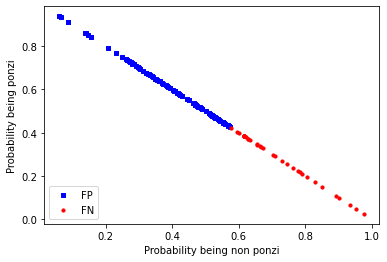

In [27]:
# rappresento i contratti su di un grafico
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x_fp, y_fp, s=10, c='b', marker="s", label='FP')
ax1.scatter(x_fn, y_fn, s=10, c='r', marker="o", label='FN')
plt.xlabel("Probability being non ponzi")
plt.ylabel("Probability being ponzi")
plt.legend(loc='lower left');
plt.show()

In [25]:
# Creo un dataframe contenente i Falsi positivi e i Falsi negativi, saranno successivamente scritti su di un file csv.
X_test_wrong_false_positive = []

for i in fp_list:
    X_test_wrong_false_positive.append(X_test_address[i, :])

df_FP = pd.DataFrame(data = X_test_wrong_false_positive, columns = features_names.insert(0, 'addresses'))

X_test_wrong_false_negative = []

for i in fn_list:
    X_test_wrong_false_negative.append(X_test_address[i, :])

df_FN = pd.DataFrame(data = X_test_wrong_false_negative, columns = features_names.insert(0, 'addresses'))

df_FN.to_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned+\fbeta\false negative.csv')
df_FP.to_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned+\fbeta\false positive.csv')

In [29]:
# acquisico le probabilita' dei contratti di essere Ponzi
prob_of_being_ponzi = coordinates[:, 1]
prob_of_being_ponzi
y_test_list = [item for sublist in y_test for item in sublist]
paired_hist_data = list(zip(y_test_list, prob_of_being_ponzi))

In [30]:
# preparo i dati per la creazione dell'istogramma
ponzi_hist = []
non_ponzi_hist = []

for t in paired_hist_data:
    if t[0] == 1:
        ponzi_hist.append(t[1])
    else:
        non_ponzi_hist.append(t[1])

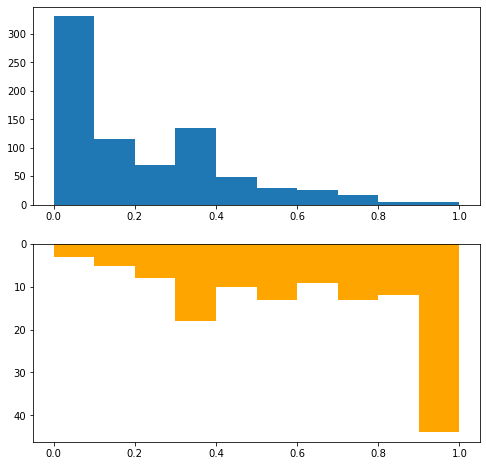

In [31]:
# costruisco l'istogramma che mantiene le probabilita' delle classificazioni
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

ax.hist(non_ponzi_hist, bins = bins, align = 'mid')
ax2.hist(ponzi_hist, color = 'orange', bins = bins, align = 'mid')
ax2.invert_yaxis()

In [18]:
# ottengo le predizioni sul test set sotto forma di 0 e 1, farlo sul modello scelto dunque quello proveniente da pr-curve
y_test_list = [item for sublist in y_test for item in sublist]
y_pred_list = y_pred_thrs.tolist()

y_pred_file = open(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned+\fbeta\y_pred_list.txt', "w")
for element in y_pred_list:
    y_pred_file.write(str(element) + "\n")
y_pred_file.close()